# Run PCA on different artificial neural recordings

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import decomposition
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import load_npy
from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

MASK_PFX = 'data/simple/masks/mask'


In [2]:
# SPECIFY STRAINS USED
STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

Load masks

In [3]:
masks = []

for itr in ISTRAIN:
    fmask = f'{MASK_PFX}_tr_{itr}.npy'
    mtr = np.load(fmask, allow_pickle=True)[0]['mask']
    masks.append(mtr)

# Initial MA ppln

In [4]:
## load full recording data
rs_mas = []

for itr, mtr in zip(ISTRAIN, masks):
    # neural data
    ftr = f'data/simple/mlv/neur_basic/baker_ma/mlv_baker_ma_tr_{itr}.npy'
    df = np.load(ftr, allow_pickle=True)[0]['df']
    r_cols = [f'R_{cr}' for cr in range(224)]
    rs_ma = np.array(df[r_cols])
    
    # mask
    rs_mas.append(rs_ma[mtr, :])
    
rs_ma_all = cc(rs_mas, axis=0)

In [5]:
pca_all = decomposition.PCA().fit(rs_ma_all)
var_exp_ma_all = pca_all.explained_variance_ratio_

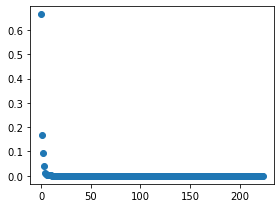

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.scatter(range(224), var_exp_ma_all)

# 20 fast-adapt, slow-integrate MA neurons

In [7]:
# record activity on the fly
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_trs = [df_behav[df_behav.ID == i] for i in ISTRAIN]
df_behav = None

In [8]:
N = 20

rtau_r = [20, 60]
rtau_a = [.1, 2]

tau_rs = np.random.uniform(*rtau_r, N)
tau_as = np.random.uniform(*rtau_a, N)
x_ss = np.random.uniform(0, 1, N)
x_ps = 1 - x_ss

params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}

In [9]:
rs_20_mas = []

for df_tr, mtr in zip(df_trs, masks):
    t = np.array(df_tr['T'])
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    b = np.zeros(len(t), dtype=int)
    b[i_s == 1] = 1
    b[i_p == 1] = 2

    # simulate population response
    rs_20_ma = smlt_ma(i_s, i_p, params, DT)
    sys.stdout.write('.')
    
    rs_20_mas.append(rs_20_ma)
    
rs_20_ma_all = cc(rs_20_mas, axis=0)

.......................................................................................

In [10]:
pca_20 = decomposition.PCA().fit(rs_20_ma_all)
var_exp_ma_20 = pca_20.explained_variance_ratio_

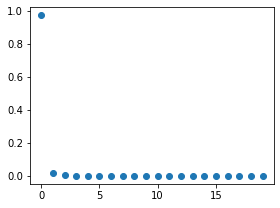

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.scatter(range(N), var_exp_ma_20)

In [12]:
var_exp_ma_20

array([9.76790655e-01, 1.65511142e-02, 4.88744084e-03, 1.13269798e-03,
       2.84429738e-04, 2.07511092e-04, 8.12192354e-05, 4.65178956e-05,
       7.98373994e-06, 4.78496232e-06, 2.14855926e-06, 1.75870365e-06,
       7.43336614e-07, 4.52667582e-07, 3.01741442e-07, 1.71629957e-07,
       3.93843350e-08, 2.15024671e-08, 6.06973387e-09, 1.63753404e-09])

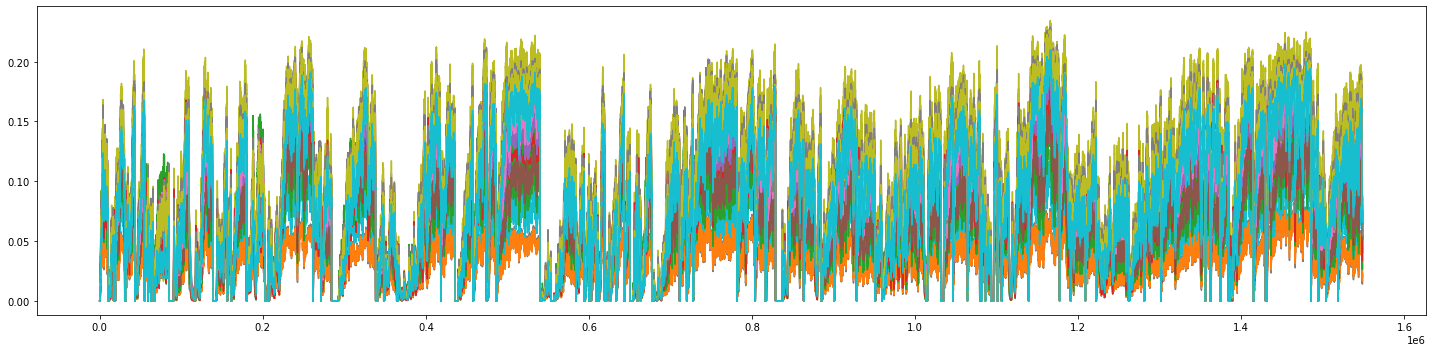

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), tight_layout=True)
ax.plot(rs_20_ma_all)
# ax.set_xlim(0, 10000)

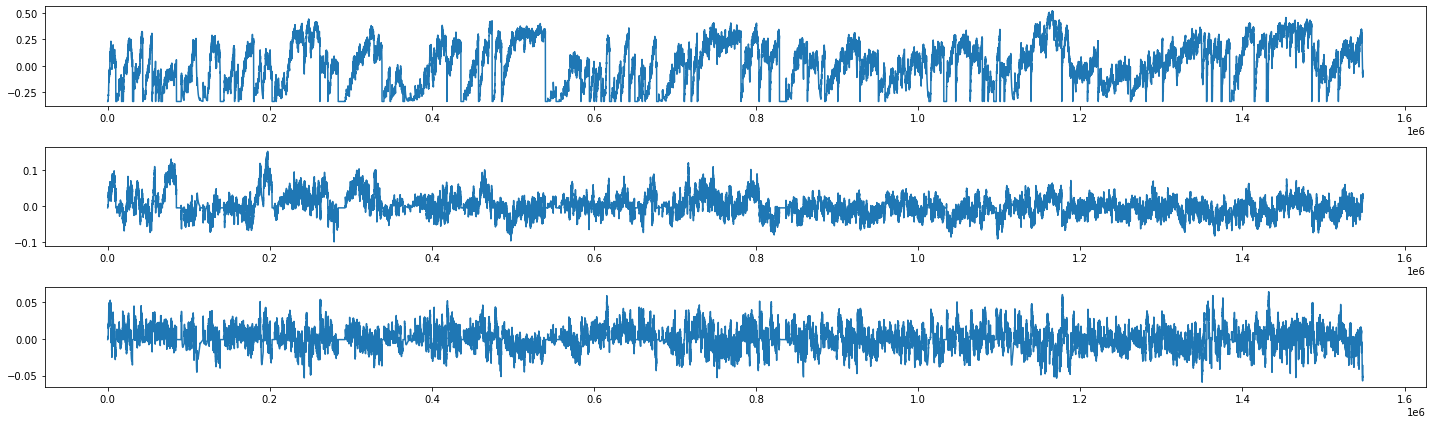

In [14]:
rs_20_all_pcs = pca_20.transform(rs_20_ma_all)

fig, axs = plt.subplots(3, 1, figsize=(20, 6), tight_layout=True)
axs[0].plot(rs_20_all_pcs[:, 0])
axs[1].plot(rs_20_all_pcs[:, 1])
axs[2].plot(rs_20_all_pcs[:, 2])